![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/PySpark/6.PySpark_Classification.ipynb)


# **PySpark Tutorial-6 Classification**


# **Overview**

In this notebook, linear regression is performed for the titanic dataset using PySpark.


## **LOGISTIC REGRESSION**


Logistic Regression is one of the most simple and commonly used Machine Learning algorithms for two-class classification. It is easy to implement and can be used as the baseline for any binary classification problem. Its basic fundamental concepts are also constructive in deep learning. Logistic regression describes and estimates the relationship between one dependent binary variable and independent variables.

Logistic regression is a statistical method for predicting binary classes. The outcome or target variable is dichotomous in nature. Dichotomous means there are only two possible classes. For example, it can be used for cancer detection problems. It computes the probability of an event occurrence.

It is a special case of linear regression where the target variable is categorical in nature. It uses a log of odds as the dependent variable. Logistic Regression predicts the probability of occurrence of a binary event utilizing a logit function.

[link text](https://www.datacamp.com/community/tutorials/understanding-logistic-regression-python)


### **Install spark**


In [2]:
%pip install -q pyspark==3.5.6 spark-nlp==6.0.4 scikit-learn==1.7.0 datasets seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.4/317.4 MB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 718.8/718.8 kB 37.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.5/12.5 MB 17.3 MB/s eta 0:00:00


### **Import Library**


In [3]:
from pyspark.sql import SparkSession
import os
import sys

from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator

from sparknlp.annotator import *
from sparknlp.common import *
from sparknlp.base import *

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, accuracy_score

#### **Start Session**


In [4]:
import sparknlp

spark = sparknlp.start()

print("Spark NLP version: ", sparknlp.version())
print("Apache Spark version: ", spark.version)
spark

Spark NLP version:  6.0.4
Apache Spark version:  3.5.6


#### **Download Dataset**


In [5]:
# Run these lines to fetch the sample dataset if you are on Colab
!mkdir -p ./data
!wget -q -P ./data https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/PySpark/data/titanic.csv

In [6]:
titanic = spark.read.csv("./data/titanic.csv", inferSchema=True, header=True)

#### **EDA**


In [7]:
titanic.printSchema()

root
 |-- Passengerid: integer (nullable = true)
 |-- Age: double (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Sex: integer (nullable = true)
 |-- sibsp: integer (nullable = true)
 |-- zero5: integer (nullable = true)
 |-- zero6: integer (nullable = true)
 |-- zero7: integer (nullable = true)
 |-- zero8: integer (nullable = true)
 |-- zero9: integer (nullable = true)
 |-- zero10: integer (nullable = true)
 |-- zero11: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- zero13: integer (nullable = true)
 |-- zero14: integer (nullable = true)
 |-- zero15: integer (nullable = true)
 |-- zero16: integer (nullable = true)
 |-- zero17: integer (nullable = true)
 |-- zero18: integer (nullable = true)
 |-- zero19: integer (nullable = true)
 |-- zero20: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- zero22: integer (nullable = true)
 |-- zero23: integer (nullable = true)
 |-- Embarked: integer (nullable = true)
 |-- zero25: integer (nullable

In [8]:
titanic.describe().show()

+-------+-----------------+------------------+-----------------+------------------+------------------+-----+-----+-----+-----+-----+------+------+------------------+------+------+------+------+------+------+------+------+------------------+------+------+------------------+------+------+------------------+
|summary|      Passengerid|               Age|             Fare|               Sex|             sibsp|zero5|zero6|zero7|zero8|zero9|zero10|zero11|             Parch|zero13|zero14|zero15|zero16|zero17|zero18|zero19|zero20|            Pclass|zero22|zero23|          Embarked|zero25|zero26|          2urvived|
+-------+-----------------+------------------+-----------------+------------------+------------------+-----+-----+-----+-----+-----+------+------+------------------+------+------+------+------+------+------+------+------+------------------+------+------+------------------+------+------+------------------+
|  count|             1309|              1309|             1309|              1

In [9]:
titanic = titanic.withColumnRenamed(
    "2urvived", "Survived"
)  # change the column name with withColumnRenamed command

In [10]:
titanic.show(2)

+-----------+----+-------+---+-----+-----+-----+-----+-----+-----+------+------+-----+------+------+------+------+------+------+------+------+------+------+------+--------+------+------+--------+
|Passengerid| Age|   Fare|Sex|sibsp|zero5|zero6|zero7|zero8|zero9|zero10|zero11|Parch|zero13|zero14|zero15|zero16|zero17|zero18|zero19|zero20|Pclass|zero22|zero23|Embarked|zero25|zero26|Survived|
+-----------+----+-------+---+-----+-----+-----+-----+-----+-----+------+------+-----+------+------+------+------+------+------+------+------+------+------+------+--------+------+------+--------+
|          1|22.0|   7.25|  0|    1|    0|    0|    0|    0|    0|     0|     0|    0|     0|     0|     0|     0|     0|     0|     0|     0|     3|     0|     0|       2|     0|     0|       0|
|          2|38.0|71.2833|  1|    1|    0|    0|    0|    0|    0|     0|     0|    0|     0|     0|     0|     0|     0|     0|     0|     0|     1|     0|     0|       0|     0|     0|       1|
+-----------+----+--

In [11]:
titanic.columns

['Passengerid',
 'Age',
 'Fare',
 'Sex',
 'sibsp',
 'zero5',
 'zero6',
 'zero7',
 'zero8',
 'zero9',
 'zero10',
 'zero11',
 'Parch',
 'zero13',
 'zero14',
 'zero15',
 'zero16',
 'zero17',
 'zero18',
 'zero19',
 'zero20',
 'Pclass',
 'zero22',
 'zero23',
 'Embarked',
 'zero25',
 'zero26',
 'Survived']

In many cases, NULL on columns needs to handles before you performing any operations on columns as operations on NULL values results in unexpected values.
https://sparkbyexamples.com/pyspark/pyspark-filter-rows-with-null-values/


In [12]:
titanic.filter("Embarked is NULL").show()

+-----------+----+----+---+-----+-----+-----+-----+-----+-----+------+------+-----+------+------+------+------+------+------+------+------+------+------+------+--------+------+------+--------+
|Passengerid| Age|Fare|Sex|sibsp|zero5|zero6|zero7|zero8|zero9|zero10|zero11|Parch|zero13|zero14|zero15|zero16|zero17|zero18|zero19|zero20|Pclass|zero22|zero23|Embarked|zero25|zero26|Survived|
+-----------+----+----+---+-----+-----+-----+-----+-----+-----+------+------+-----+------+------+------+------+------+------+------+------+------+------+------+--------+------+------+--------+
|         62|38.0|80.0|  1|    0|    0|    0|    0|    0|    0|     0|     0|    0|     0|     0|     0|     0|     0|     0|     0|     0|     1|     0|     0|    NULL|     0|     0|       1|
|        830|62.0|80.0|  1|    0|    0|    0|    0|    0|    0|     0|     0|    0|     0|     0|     0|     0|     0|     0|     0|     0|     1|     0|     0|    NULL|     0|     0|       1|
+-----------+----+----+---+-----+--

In [13]:
titanic = titanic.filter("Embarked is not NULL")

In [14]:
titanic.groupBy("survived").pivot("pclass").count().show()

+--------+---+---+---+
|survived|  1|  2|  3|
+--------+---+---+---+
|       1|134| 87|119|
|       0|187|190|590|
+--------+---+---+---+



<Axes: >

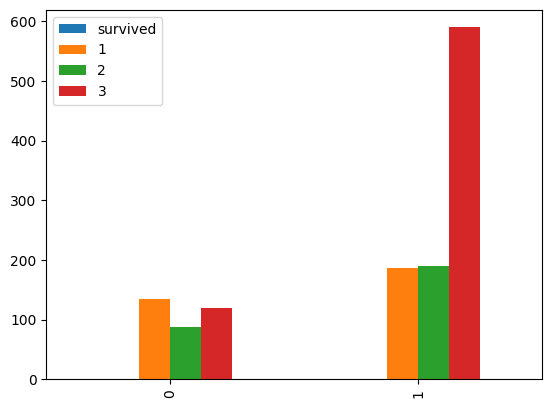

In [15]:
titanic.groupBy("survived").pivot("pclass").count().toPandas().plot(kind="bar")

In [16]:
titanic.groupBy("survived").pivot("Sex").count().show()

+--------+---+---+
|survived|  0|  1|
+--------+---+---+
|       1|109|231|
|       0|734|233|
+--------+---+---+



<Axes: >

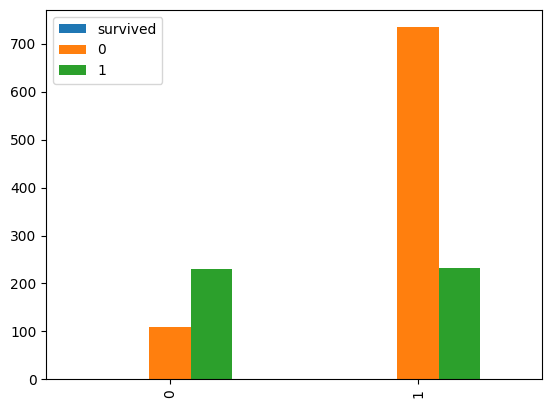

In [17]:
titanic.groupBy("survived").pivot("Sex").count().toPandas().plot(kind="bar")

#### **Import ML Libraries**


In [18]:
from pyspark.ml.feature import VectorAssembler
import seaborn as sns

#### **Preparing Data for Regression**


In [19]:
assembler2 = VectorAssembler(
    inputCols=["Age", "Fare", "Sex", "Pclass", "Embarked"], outputCol="features"
)

In [20]:
output2 = assembler2.transform(titanic)

In [21]:
final_data2 = output2.select("features", "Survived")

In [22]:
final_data2.show(5)

+--------------------+--------+
|            features|Survived|
+--------------------+--------+
|[22.0,7.25,0.0,3....|       0|
|[38.0,71.2833,1.0...|       1|
|[26.0,7.925,1.0,3...|       1|
|[35.0,53.1,1.0,1....|       1|
|[35.0,8.05,0.0,3....|       0|
+--------------------+--------+
only showing top 5 rows



In [23]:
data = output2.select("Age", "Fare", "Sex", "Pclass", "Embarked", "Survived").toPandas()

<Axes: >

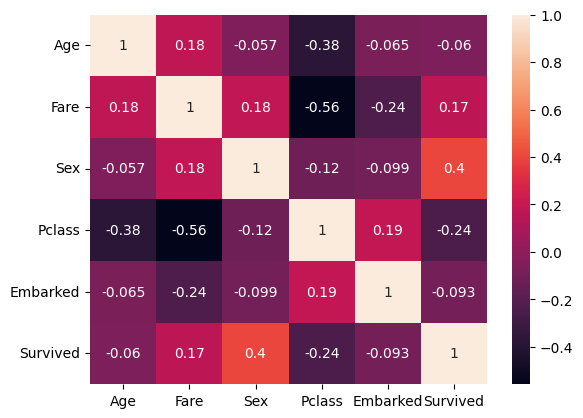

In [24]:
sns.heatmap(data.corr(), annot=True)

#### **Train Test Split**


In [25]:
train_titanic, test_titanic = final_data2.randomSplit([0.7, 0.3], seed=42)

In [26]:
train_titanic.describe().show()

+-------+-------------------+
|summary|           Survived|
+-------+-------------------+
|  count|                960|
|   mean|0.24791666666666667|
| stddev| 0.4320282612185047|
|    min|                  0|
|    max|                  1|
+-------+-------------------+



In [27]:
test_titanic.describe().show()

+-------+-------------------+
|summary|           Survived|
+-------+-------------------+
|  count|                347|
|   mean|0.29394812680115273|
| stddev| 0.4562263251163177|
|    min|                  0|
|    max|                  1|
+-------+-------------------+



### **Logistic Regression**


Logistic regression is a popular method to predict a categorical response. It is a special case of Generalized Linear models that predicts the probability of the outcomes. In spark.ml logistic regression can be used to predict a binary outcome by using binomial logistic regression, or it can be used to predict a multiclass outcome by using multinomial logistic regression.

[link text](https://spark.apache.org/docs/latest/ml-classification-regression.html#logistic-regression)


In [28]:
from pyspark.ml.classification import LogisticRegression

In [29]:
logistic_regression = LogisticRegression(featuresCol="features", labelCol="Survived")

In [30]:
logistic_model = logistic_regression.fit(train_titanic)

In [31]:
predictions = logistic_model.transform(test_titanic)

In [32]:
predictions.select("prediction", "Survived", "features").show(truncate=False)

+----------+--------+--------------------------+
|prediction|Survived|features                  |
+----------+--------+--------------------------+
|0.0       |1       |[0.42,8.5167,0.0,3.0,0.0] |
|0.0       |1       |[0.75,19.2583,1.0,3.0,0.0]|
|0.0       |1       |[0.83,18.75,0.0,2.0,2.0]  |
|0.0       |1       |[0.83,29.0,0.0,2.0,2.0]   |
|0.0       |0       |[1.0,12.1833,1.0,3.0,2.0] |
|0.0       |1       |[1.0,15.7417,1.0,3.0,0.0] |
|0.0       |0       |[1.0,16.7,1.0,3.0,2.0]    |
|0.0       |0       |[1.0,39.6875,0.0,3.0,2.0] |
|0.0       |0       |[1.0,46.9,0.0,3.0,2.0]    |
|0.0       |1       |[2.0,12.2875,1.0,3.0,2.0] |
|0.0       |0       |[2.0,20.2125,1.0,3.0,2.0] |
|1.0       |1       |[2.0,26.0,1.0,2.0,2.0]    |
|0.0       |0       |[2.0,27.9,1.0,3.0,2.0]    |
|0.0       |0       |[2.0,29.125,0.0,3.0,1.0]  |
|0.0       |0       |[2.0,39.6875,0.0,3.0,2.0] |
|0.0       |0       |[3.0,13.775,1.0,3.0,2.0]  |
|0.0       |1       |[3.0,15.9,0.0,3.0,2.0]    |
|0.0       |1       

In [33]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.classification import LogisticRegressionWithLBFGS
from pyspark.mllib.util import MLUtils
from pyspark.mllib.evaluation import MulticlassMetrics

In [34]:
pred_and_labels = logistic_model.evaluate(test_titanic)

In [35]:
pred_and_labels.predictions.show()

+--------------------+--------+--------------------+--------------------+----------+
|            features|Survived|       rawPrediction|         probability|prediction|
+--------------------+--------+--------------------+--------------------+----------+
|[0.42,8.5167,0.0,...|       1|[1.84838590671855...|[0.86393747854589...|       0.0|
|[0.75,19.2583,1.0...|       1|[0.04390346318550...|[0.51097410312481...|       0.0|
|[0.83,18.75,0.0,2...|       1|[1.18229618506882...|[0.76536041275004...|       0.0|
|[0.83,29.0,0.0,2....|       1|[1.18666881455089...|[0.76614475505300...|       0.0|
|[1.0,12.1833,1.0,...|       0|[0.15974206199408...|[0.53985081034108...|       0.0|
|[1.0,15.7417,1.0,...|       1|[0.04793992543081...|[0.51198268652502...|       0.0|
|[1.0,16.7,1.0,3.0...|       0|[0.16166887717278...|[0.54032941728747...|       0.0|
|[1.0,39.6875,0.0,...|       0|[1.98784844777968...|[0.87951532770222...|       0.0|
|[1.0,46.9,0.0,3.0...|       0|[1.99092528584206...|[0.8798409938

#### **AUC - ROC**

AUC - ROC curve is a performance measurement for the classification problems at various threshold settings. ROC is a probability curve and AUC represents the degree or measure of separability. It tells how much the model is capable of distinguishing between classes. Higher the AUC, the better the model is at predicting 0 classes as 0 and 1 classes as 1.

[link text](https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5)


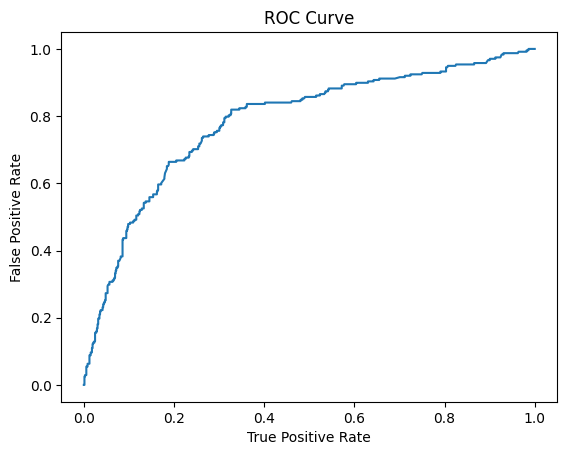

Training set areaUnderROC: 0.7838782327335362


In [36]:
import matplotlib.pyplot as plt
import numpy as np

trainingSummary = logistic_model.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc["FPR"], roc["TPR"])
plt.ylabel("False Positive Rate")
plt.xlabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()
print("Training set areaUnderROC: " + str(trainingSummary.areaUnderROC))

In [37]:
churn_eval = BinaryClassificationEvaluator(
    rawPredictionCol="prediction", labelCol="Survived"
)

In [38]:
auc = churn_eval.evaluate(pred_and_labels.predictions)

In [39]:
auc

# The Area Under the Curve (AUC) is the measure of the ability of a classifier to distinguish between classes and is used as a summary of the ROC curve.
# The higher the AUC, the better the performance of the model at distinguishing between the positive and negative classes.

# https://www.analyticsvidhya.com/blog/2020/06/auc-roc-curve-machine-learning/#:~:text=The%20Area%20Under%20the%20Curve,the%20positive%20and%20negative%20classes.

0.662204881952781

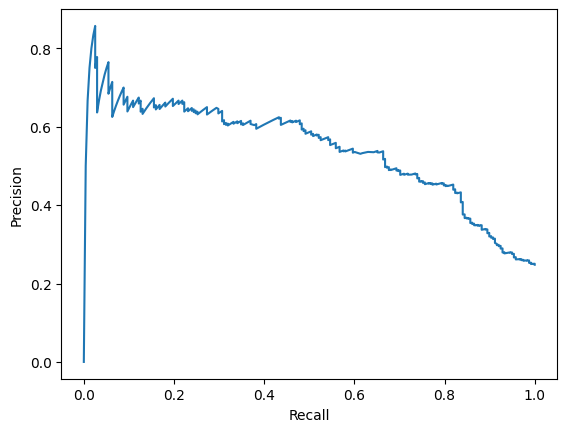

In [40]:
# precision and recall
pr = trainingSummary.pr.toPandas()
plt.plot(pr["recall"], pr["precision"])
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.show()

## **Decision Tree Classifier**


Decision trees and their ensembles are popular methods for the machine learning tasks of classification and regression. Decision trees are widely used since they are easy to interpret, handle categorical features, extend to the multiclass classification setting, do not require feature scaling, and are able to capture non-linearities and feature interactions.

[link text](https://spark.apache.org/docs/latest/ml-classification-regression.html#decision-trees)


In [41]:
from pyspark.ml.classification import DecisionTreeClassifier

dt = DecisionTreeClassifier(featuresCol="features", labelCol="Survived", maxDepth=3)
dtModel = dt.fit(train_titanic)
predictions = dtModel.transform(test_titanic)
predictions.select(
    "prediction", "Survived", "features", "rawPrediction", "probability"
).show(10)

+----------+--------+--------------------+-------------+--------------------+
|prediction|Survived|            features|rawPrediction|         probability|
+----------+--------+--------------------+-------------+--------------------+
|       0.0|       1|[0.42,8.5167,0.0,...|    [6.0,2.0]|         [0.75,0.25]|
|       0.0|       1|[0.75,19.2583,1.0...| [110.0,48.0]|[0.69620253164556...|
|       1.0|       1|[0.83,18.75,0.0,2...|    [1.0,8.0]|[0.11111111111111...|
|       1.0|       1|[0.83,29.0,0.0,2....|    [1.0,8.0]|[0.11111111111111...|
|       0.0|       0|[1.0,12.1833,1.0,...| [110.0,48.0]|[0.69620253164556...|
|       0.0|       1|[1.0,15.7417,1.0,...| [110.0,48.0]|[0.69620253164556...|
|       0.0|       0|[1.0,16.7,1.0,3.0...| [110.0,48.0]|[0.69620253164556...|
|       0.0|       0|[1.0,39.6875,0.0,...|    [6.0,2.0]|         [0.75,0.25]|
|       0.0|       0|[1.0,46.9,0.0,3.0...|    [6.0,2.0]|         [0.75,0.25]|
|       0.0|       1|[2.0,12.2875,1.0,...| [110.0,48.0]|[0.69620

In [42]:
## Evaluate our Decision Tree model.

evaluator = BinaryClassificationEvaluator(
    rawPredictionCol="prediction", labelCol="Survived"
)
print(
    "Test Area Under ROC: "
    + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"}))
)

Test Area Under ROC: 0.6891756702681073


## **Random Forest Classifier**


Random forests are ensembles of decision trees. Random forests are one of the most successful machine learning models for classification and regression. They combine many decision trees in order to reduce the risk of overfitting. Like decision trees, random forests handle categorical features, extend to the multiclass classification setting, do not require feature scaling, and are able to capture non-linearities and feature interactions.

[link text](https://spark.apache.org/docs/latest/mllib-ensembles.html#random-forests)


In [43]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(featuresCol="features", labelCol="Survived")
rfModel = rf.fit(train_titanic)
predictions = rfModel.transform(test_titanic)
predictions.select(
    "prediction", "Survived", "features", "rawPrediction", "probability"
).show(10)

+----------+--------+--------------------+--------------------+--------------------+
|prediction|Survived|            features|       rawPrediction|         probability|
+----------+--------+--------------------+--------------------+--------------------+
|       0.0|       1|[0.42,8.5167,0.0,...|[15.1638854455322...|[0.75819427227661...|
|       0.0|       1|[0.75,19.2583,1.0...|[10.3786677583751...|[0.51893338791875...|
|       1.0|       1|[0.83,18.75,0.0,2...|[5.34636431518901...|[0.26731821575945...|
|       1.0|       1|[0.83,29.0,0.0,2....|[3.02444083694083...|[0.15122204184704...|
|       0.0|       0|[1.0,12.1833,1.0,...|[13.2013485945004...|[0.66006742972502...|
|       0.0|       1|[1.0,15.7417,1.0,...|[13.2954894162494...|[0.66477447081247...|
|       0.0|       0|[1.0,16.7,1.0,3.0...|[14.4635884205333...|[0.72317942102666...|
|       0.0|       0|[1.0,39.6875,0.0,...|[16.1427997944956...|[0.80713998972478...|
|       0.0|       0|[1.0,46.9,0.0,3.0...|[16.1427997944956...|[0

In [44]:
## Evaluate our Random Forest Classifier.

evaluator = BinaryClassificationEvaluator(
    rawPredictionCol="prediction", labelCol="Survived"
)
print(
    "Test Area Under ROC: "
    + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"}))
)

Test Area Under ROC: 0.683453381352541


## **Gradient-Boosted Tree Classifier**


Gradient-Boosted Trees (GBTs) are ensembles of decision trees. GBTs iteratively train decision trees in order to minimize a loss function. Like decision trees, GBTs handle categorical features, extend to the multiclass classification setting, do not require feature scaling, and are able to capture non-linearities and feature interactions.

[link text](https://spark.apache.org/docs/latest/mllib-ensembles.html#gradient-boosted-trees-gbts)


In [45]:
from pyspark.ml.classification import GBTClassifier

gbt = GBTClassifier(featuresCol="features", labelCol="Survived", maxIter=10)
gbtModel = gbt.fit(train_titanic)
predictions = gbtModel.transform(test_titanic)
predictions.select(
    "prediction", "Survived", "features", "rawPrediction", "probability"
).show(10)

+----------+--------+--------------------+--------------------+--------------------+
|prediction|Survived|            features|       rawPrediction|         probability|
+----------+--------+--------------------+--------------------+--------------------+
|       0.0|       1|[0.42,8.5167,0.0,...|[0.70585953118645...|[0.80403694331760...|
|       0.0|       1|[0.75,19.2583,1.0...|[0.30426169954702...|[0.64760389591594...|
|       1.0|       1|[0.83,18.75,0.0,2...|[-1.0645228122018...|[0.10630562782001...|
|       1.0|       1|[0.83,29.0,0.0,2....|[-1.1801533002286...|[0.08625002795387...|
|       0.0|       0|[1.0,12.1833,1.0,...|[0.17146790887485...|[0.58490349143189...|
|       0.0|       1|[1.0,15.7417,1.0,...|[0.46289572236548...|[0.71622068138642...|
|       0.0|       0|[1.0,16.7,1.0,3.0...|[0.54875209976720...|[0.74979217573674...|
|       0.0|       0|[1.0,39.6875,0.0,...|[1.22384925034696...|[0.92039298363395...|
|       0.0|       0|[1.0,46.9,0.0,3.0...|[1.22384925034696...|[0

In [46]:
## Evaluate our Gradient-Boosted Tree Classifier.

evaluator = BinaryClassificationEvaluator(
    rawPredictionCol="prediction", labelCol="Survived"
)
print(
    "Test Area Under ROC: "
    + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"}))
)

Test Area Under ROC: 0.671608643457383


# **NLP Session**


### **Import Data and Analysis**


In [47]:
%pip install datasets

In [48]:
import datasets
from datasets import load_dataset

In [49]:
dataset = load_dataset("sms_spam")
df = pd.DataFrame(dataset["train"])
df.head()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/359k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/5574 [00:00<?, ? examples/s]

,sms,label
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...\n,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0


In [50]:
df.rename(columns={"sms": "text"}, inplace=True)

In [51]:
df.shape

(5574, 2)

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5574 entries, 0 to 5573
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5574 non-null   object
 1   label   5574 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 87.2+ KB


In [53]:
df[(df.text == "") | (df.label == "")]  ## doesn't have null values

,text,label


In [54]:
df.head()

,text,label
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...\n,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0


In [55]:
spark_df = spark.createDataFrame(df)
spark_df.printSchema()

root
 |-- text: string (nullable = true)
 |-- label: long (nullable = true)



In [56]:
spark_df.show(truncate=False)

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|text                                                                                                                                                                                                  |label|
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...\n                                                                                     |0    |
|Ok lar... Joking wif u oni...\n                                                                                                                                            

In [57]:
spark_df.take(2)

[Row(text='Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...\n', label=0),
 Row(text='Ok lar... Joking wif u oni...\n', label=0)]

In [58]:
from pyspark.sql.functions import col

spark_df.groupBy("label").count().show()

# 0 = ham, 1 = spam

+-----+-----+
|label|count|
+-----+-----+
|    0| 4827|
|    1|  747|
+-----+-----+



### **Pipeline**


In [65]:
from pyspark.ml.feature import (
    CountVectorizer,
    HashingTF,
    IDF,
    OneHotEncoder,
    StringIndexer,
    VectorAssembler,
    SQLTransformer,
)
from pyspark.ml.classification import LogisticRegression, NaiveBayes
from pyspark.sql.functions import when

In [ ]:
# Run this if you are on Midway
MODEL_DIR = "../models"

stopwords_model_path = os.path.join(
    MODEL_DIR, "stopwords_en_en_2.5.4_2.4_1594742439135"
)
lemma_model_path = os.path.join(MODEL_DIR, "lemma_antbnc_en_2.0.2_2.4_1556480454569")

In [63]:
import os
import urllib.request

def has_internet(timeout: int = 3) -> bool:
    try:
        urllib.request.urlopen("https://clients3.google.com/generate_204", timeout=timeout)
        return True
    except Exception:
        return False

online_ok = has_internet()
online_ok

True

In [64]:
# Stages that don't need pretrained weights
document_assembler = DocumentAssembler().setInputCol("text").setOutputCol("document")
tokenizer = Tokenizer().setInputCols(["document"]).setOutputCol("token")
normalizer = Normalizer().setInputCols(["token"]).setOutputCol("normalized")

# Use online pretrained models if internet is available; otherwise use local paths
if online_ok:
    # 'stopwords_en' and 'lemma_antbnc' are the common English pretrained packages
    stop_words = (
        StopWordsCleaner.pretrained("stopwords_en", "en")
        .setInputCols(["normalized"])
        .setOutputCol("cleanTokens")
        .setCaseSensitive(False)
    )
    lemmatizer = (
        LemmatizerModel.pretrained("lemma_antbnc", "en")
        .setInputCols(["cleanTokens"])
        .setOutputCol("lemma")
    )
else:
    stop_words = (
        StopWordsCleaner.load(stopwords_model_path)
        .setInputCols(["normalized"])
        .setOutputCol("cleanTokens")
        .setCaseSensitive(False)
    )
    lemmatizer = (
        LemmatizerModel.load(lemma_model_path)
        .setInputCols(["cleanTokens"])
        .setOutputCol("lemma")
    )

finisher = (
    Finisher()
    .setInputCols(["lemma"])
    .setOutputCols(["token_features"])
    .setOutputAsArray(True)
    .setCleanAnnotations(False)
)


stopwords_en download started this may take some time.
Approximate size to download 2.9 KB
[OK!]
lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]


In [66]:
hashTF = HashingTF(inputCol="token_features", outputCol="raw_features")

idf = IDF(
    inputCol="raw_features", outputCol="features", minDocFreq=5
)  # minDocFreq: minimum of documents in which a term should appear for filtering

countVectors = CountVectorizer(
    inputCol="token_features", outputCol="features", vocabSize=100000, minDF=5
)

### https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.feature.CountVectorizer.html

In [67]:
pipeline_count = Pipeline(
    stages=[
        document_assembler,
        tokenizer,
        normalizer,
        stop_words,
        lemmatizer,
        finisher,
        countVectors,
    ]
)

cnt_model_pipeline = pipeline_count.fit(spark_df)
cnt_df = cnt_model_pipeline.transform(spark_df)

In [68]:
train, test = cnt_df.randomSplit([0.8, 0.2], seed=101)

In [69]:
print(train.count())
train.show(5)

4430
+--------------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|                text|label|            document|               token|          normalized|         cleanTokens|               lemma|      token_features|            features|
+--------------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
| &lt;#&gt;  mins ...|    0|[{document, 0, 51...|[{token, 1, 8, &l...|[{token, 1, 4, lt...|[{token, 1, 4, lt...|[{token, 1, 4, lt...|   [ltgt, min, stop]|(1379,[3,45,49],[...|
| and  picking the...|    0|[{document, 0, 41...|[{token, 1, 3, an...|[{token, 1, 3, an...|[{token, 6, 12, p...|[{token, 6, 12, p...|       [pick, point]|(1379,[42,212],[1...|
| gonna let me kno...|    0|[{document, 0, 95...|[{token, 1, 5, go...|[{token, 1, 5, go...|[{token, 1, 5, go...|[{t

In [70]:
train.groupBy("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|    0| 3844|
|    1|  586|
+-----+-----+



In [71]:
print(test.count())
test.show(5)

1144
+--------------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|                text|label|            document|               token|          normalized|         cleanTokens|               lemma|      token_features|            features|
+--------------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|"AH POOR BABY!HOP...|    0|[{document, 0, 11...|[{token, 0, 0, ",...|[{token, 1, 2, AH...|[{token, 1, 2, AH...|[{token, 1, 2, AH...|[AH, POOR, BABYHO...|(1379,[409,650,87...|
|"Happy valentines...|    0|[{document, 0, 14...|[{token, 0, 0, ",...|[{token, 1, 5, Ha...|[{token, 1, 5, Ha...|[{token, 1, 5, Ha...|[Happy, valentine...|(1379,[4,60,81,10...|
|"Hi its Kate it w...|    0|[{document, 0, 12...|[{token, 0, 0, ",...|[{token, 1, 2, Hi...|[{token, 8, 11, K...|[{t

In [72]:
test.groupBy("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|    0|  983|
|    1|  161|
+-----+-----+



### **LogReg with CountVectorizer**


In [73]:
dataset_size = float(train.select("label").count())
numSpam = train.select("label").where("label == 1").count()
per_ones = (float(numSpam) / float(dataset_size)) * 100
numHam = float(dataset_size - numSpam)
print("The number of negative ones are {}".format(numSpam))
print("The number of positive ones are {}".format(numHam))
print("Percentage of ratio negative ones are {}".format(per_ones))


BalancingRatio = numHam / dataset_size
print("BalancingRatio = {}".format(BalancingRatio))

train = train.withColumn(
    "classWeights", when(train.label == 1, BalancingRatio).otherwise(1 - BalancingRatio)
)
train.show(5)

The number of negative ones are 586
The number of positive ones are 3844.0
Percentage of ratio negative ones are 13.227990970654627
BalancingRatio = 0.8677200902934538
+--------------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+
|                text|label|            document|               token|          normalized|         cleanTokens|               lemma|      token_features|            features|       classWeights|
+--------------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+
| &lt;#&gt;  mins ...|    0|[{document, 0, 51...|[{token, 1, 8, &l...|[{token, 1, 4, lt...|[{token, 1, 4, lt...|[{token, 1, 4, lt...|   [ltgt, min, stop]|(1379,[3,45,49],[...|0.13227990970654624|
| and  picking the...|    0|[{document, 0, 41...

In [74]:
log = LogisticRegression(
    featuresCol="features", labelCol="label", maxIter=10, weightCol="classWeights"
)

In [75]:
lr_cnt_model = log.fit(train)

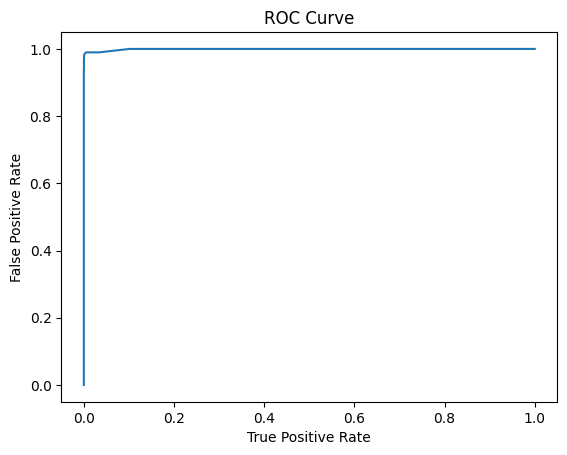

Training set areaUnderROC: 0.9992828236372095


In [76]:
trainingSummary = lr_cnt_model.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc["FPR"], roc["TPR"])
plt.ylabel("False Positive Rate")
plt.xlabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()
print("Training set areaUnderROC: " + str(trainingSummary.areaUnderROC))

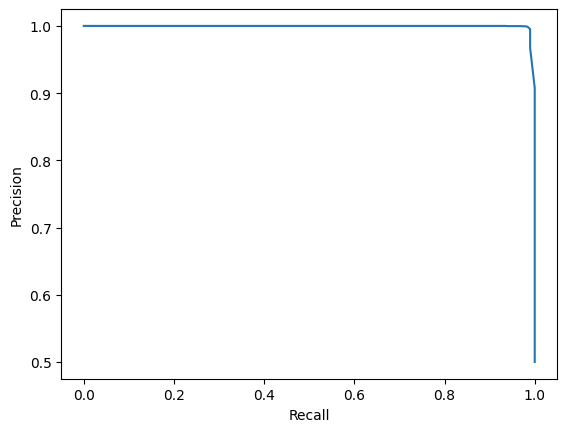

In [77]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr["recall"], pr["precision"])
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.show()

In [78]:
preds = lr_cnt_model.transform(test)

In [79]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC", evaluator.evaluate(preds))

Test Area Under ROC 0.9847658644155605


In [80]:
lg_cnt_pred = preds.select("label", "prediction").toPandas()
lg_cnt_pred.head()

,label,prediction
0,0,0.0
1,0,0.0
2,0,0.0
3,0,0.0
4,0,0.0


In [81]:
print(classification_report(lg_cnt_pred.label, lg_cnt_pred.prediction))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       983
           1       0.84      0.91      0.87       161

    accuracy                           0.96      1144
   macro avg       0.91      0.94      0.93      1144
weighted avg       0.96      0.96      0.96      1144



### **LogReg Tfidf**


In [82]:
pipeline_tfidf = Pipeline(
    stages=[
        document_assembler,
        tokenizer,
        normalizer,
        stop_words,
        lemmatizer,
        finisher,
        hashTF,
        idf,
    ]
)

tfidf_model_pipeline = pipeline_tfidf.fit(spark_df)
tfidf_df = tfidf_model_pipeline.transform(spark_df)

In [83]:
tfidf_df.show(2)

+--------------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|                text|label|            document|               token|          normalized|         cleanTokens|               lemma|      token_features|        raw_features|            features|
+--------------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|Go until jurong p...|    0|[{document, 0, 11...|[{token, 0, 1, Go...|[{token, 0, 1, Go...|[{token, 9, 14, j...|[{token, 9, 14, j...|[jurong, point, c...|(262144,[38555,60...|(262144,[38555,60...|
|Ok lar... Joking ...|    0|[{document, 0, 29...|[{token, 0, 1, Ok...|[{token, 0, 1, Ok...|[{token, 3, 5, la...|[{token, 3, 5, la...|[lar, Joking, wif...|(262144,[1952,168...|(262144,[1952,168...|
+--------------

In [84]:
train, test = tfidf_df.randomSplit([0.8, 0.2], seed=101)

In [85]:
dataset_size = float(train.select("label").count())
numSpam = train.select("label").where("label == 1").count()
per_ones = (float(numSpam) / float(dataset_size)) * 100
numHam = float(dataset_size - numSpam)
print("The number of negative ones are {}".format(numSpam))
print("The number of positive ones are {}".format(numHam))
print("Percentage of ratio negative ones are {}".format(per_ones))


BalancingRatio = numHam / dataset_size
print("BalancingRatio = {}".format(BalancingRatio))

train = train.withColumn(
    "classWeights", when(train.label == 1, BalancingRatio).otherwise(1 - BalancingRatio)
)

The number of negative ones are 586
The number of positive ones are 3844.0
Percentage of ratio negative ones are 13.227990970654627
BalancingRatio = 0.8677200902934538


In [86]:
log = LogisticRegression(
    featuresCol="features", labelCol="label", maxIter=10, weightCol="classWeights"
)

In [87]:
lr_tfidf_model = log.fit(train)

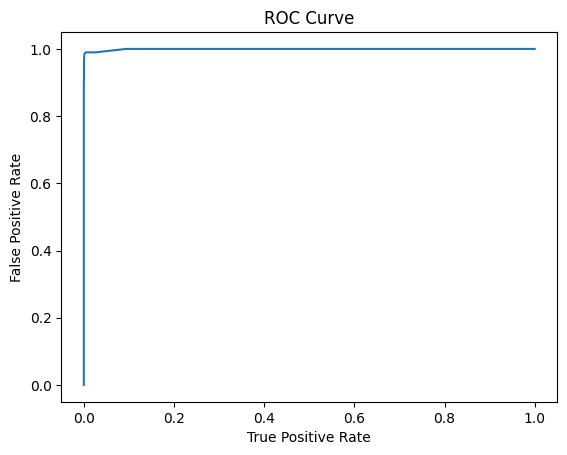

Training set areaUnderROC: 0.9993491918614356


In [88]:
trainingSummary = lr_tfidf_model.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc["FPR"], roc["TPR"])
plt.ylabel("False Positive Rate")
plt.xlabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()
print("Training set areaUnderROC: " + str(trainingSummary.areaUnderROC))

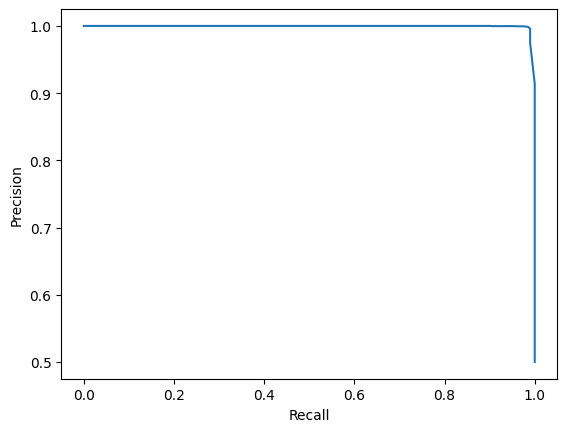

In [89]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr["recall"], pr["precision"])
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.show()

In [90]:
preds = lr_tfidf_model.transform(test)

In [91]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC", evaluator.evaluate(preds))

Test Area Under ROC 0.9813538224348068


In [92]:
lg_tfidf_pred = preds.select("label", "prediction").toPandas()
lg_tfidf_pred.head()

,label,prediction
0,0,0.0
1,0,0.0
2,0,0.0
3,0,0.0
4,0,0.0


In [93]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC", evaluator.evaluate(preds))

Test Area Under ROC 0.981353822434807


In [94]:
print(classification_report(lg_tfidf_pred.label, lg_tfidf_pred.prediction))

              precision    recall  f1-score   support

           0       0.98      0.97      0.98       983
           1       0.82      0.91      0.86       161

    accuracy                           0.96      1144
   macro avg       0.90      0.94      0.92      1144
weighted avg       0.96      0.96      0.96      1144



### **Naive Bayes Countvector**


In [95]:
from pyspark.ml.classification import (
    LogisticRegression,
    NaiveBayes,
    RandomForestClassifier,
)

train, test = cnt_df.randomSplit([0.8, 0.2], seed=101)
dataset_size = float(train.select("label").count())
numSpam = train.select("label").where("label == 1").count()
per_ones = (float(numSpam) / float(dataset_size)) * 100
numHam = float(dataset_size - numSpam)
BalancingRatio = numHam / dataset_size
train = train.withColumn(
    "classWeights", when(train.label == 1, BalancingRatio).otherwise(1 - BalancingRatio)
)

nb = NaiveBayes(featuresCol="features", labelCol="label", weightCol="classWeights")

nb_cnt_model = nb.fit(train)

In [96]:
preds = nb_cnt_model.transform(test)

In [97]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC", evaluator.evaluate(preds))

Test Area Under ROC 0.2067381510523622


In [98]:
nb_cnt_pred = preds.select("label", "prediction").toPandas()
nb_cnt_pred.head()

,label,prediction
0,0,0.0
1,0,0.0
2,0,0.0
3,0,0.0
4,0,0.0


In [99]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC", evaluator.evaluate(preds))

Test Area Under ROC 0.2067381510523622


In [100]:
print(classification_report(nb_cnt_pred.label, nb_cnt_pred.prediction))

              precision    recall  f1-score   support

           0       0.99      0.88      0.93       983
           1       0.56      0.97      0.71       161

    accuracy                           0.89      1144
   macro avg       0.78      0.92      0.82      1144
weighted avg       0.93      0.89      0.90      1144



### **Naive Bayes Tfidf**


In [101]:
from pyspark.ml.classification import (
    LogisticRegression,
    NaiveBayes,
    RandomForestClassifier,
)

train, test = tfidf_df.randomSplit([0.8, 0.2], seed=101)
dataset_size = float(train.select("label").count())
numSpam = train.select("label").where("label == 1").count()
per_ones = (float(numSpam) / float(dataset_size)) * 100
numHam = float(dataset_size - numSpam)

BalancingRatio = numHam / dataset_size
train = train.withColumn(
    "classWeights", when(train.label == 1, BalancingRatio).otherwise(1 - BalancingRatio)
)

nb = NaiveBayes(featuresCol="features", labelCol="label", weightCol="classWeights")

nb_tfidf_model = nb.fit(train)

In [102]:
preds = nb_tfidf_model.transform(test)

In [103]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC", evaluator.evaluate(preds))

Test Area Under ROC 0.20967629831356663


In [104]:
nb_tfidf_pred = preds.select("label", "prediction", "probability").toPandas()
nb_tfidf_pred.head()

,label,prediction,probability
0,0,0.0,"[0.999999999999986, 1.3890383885877763e-14]"
1,0,0.0,"[1.0, 2.4241273694379822e-23]"
2,0,0.0,"[0.9999999999999598, 4.0213136503286805e-14]"
3,0,0.0,"[0.9999999301489559, 6.985104395654447e-08]"
4,0,0.0,"[0.9991934909327025, 0.0008065090672975073]"


In [105]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC", evaluator.evaluate(preds))

Test Area Under ROC 0.20967629831356668


In [106]:
print(classification_report(nb_tfidf_pred.label, nb_tfidf_pred.prediction))

              precision    recall  f1-score   support

           0       1.00      0.84      0.91       983
           1       0.51      0.99      0.67       161

    accuracy                           0.86      1144
   macro avg       0.75      0.92      0.79      1144
weighted avg       0.93      0.86      0.88      1144

